<a href="https://colab.research.google.com/github/sunnyday2/flight_on_time/blob/desarrollo/notebook__flight_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
"""Rafaflight.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1_MHzc-KVpSGhVcqIrJn9HVOBYN5y4mOC
"""

import kagglehub


path = kagglehub.dataset_download("arvindnagaonkar/flight-delay")

print("Path to dataset files:", path)

import os

os.listdir(path)

import pyarrow.parquet as pq
import os
from pathlib import Path

parquet_file = Path("/kaggle/input/flight-delay/Flight_Delay.parquet")

# Tamaño del archivo
file_size_mb = os.path.getsize(parquet_file) / (1024 * 1024)
print(f"Tamaño del archivo: {file_size_mb:.2f} MB")

# Leer metadata completa
parquet_metadata = pq.ParquetFile(parquet_file)
num_filas = parquet_metadata.metadata.num_rows
num_columnas = parquet_metadata.metadata.num_columns

print(f"Filas: {num_filas}")
print(f"Columnas: {num_columnas}")

import pandas as pd
from pathlib import Path

Using Colab cache for faster access to the 'flight-delay' dataset.
Path to dataset files: /kaggle/input/flight-delay
Tamaño del archivo: 736.43 MB
Filas: 30132672
Columnas: 30


# Sección nueva

In [4]:
from pathlib import Path

# Ruta al archivo Parquet
parquet_file = Path("/kaggle/input/flight-delay/Flight_Delay.parquet")

# Cargar una muestra de 100k filas
df_full = pd.read_parquet(parquet_file, engine="pyarrow")  # carga todo
df = df_full.sample(n=100_000, random_state=42)  # toma muestra aleatoria

print("Shape de la muestra:", df.shape)

import pyarrow.parquet as pq
import pandas as pd

parquet_file = "/kaggle/input/flight-delay/Flight_Delay.parquet"
n_sample = 100_000

# Abrir Parquet
table = pq.ParquetFile(parquet_file)

sample_rows = []
rows_collected = 0

for batch in table.iter_batches(batch_size=50_000):
    df_batch = batch.to_pandas()  # convierte a Pandas conservando columnas

    remaining = n_sample - rows_collected
    if len(df_batch) >= remaining:
        sample_rows.append(df_batch.sample(n=remaining, random_state=42))
        break
    else:
        sample_rows.append(df_batch)
        rows_collected += len(df_batch)

# Concatenar en un único DataFrame
df_sample = pd.concat(sample_rows, ignore_index=True)

# Columnas están bien
print("Shape de la muestra:", df_sample.shape)
print("Columnas:", df_sample.columns.tolist())

# Ver los nombres de columna reales
print(df_sample.columns.tolist())

# Crear variable temporal 'hour' a partir de la hora programada
df_sample["hour"] = df_sample["CRSDepTime"] // 100  # only the hour - corrected 'crsdeptime' to 'CRSDepTime'

# Variable objetivo 'delayed': 1 si el retraso en salida >= 15 min
df_sample["delayed"] = (df_sample["DepDelay"] >= 15).astype(int)

# Probabilidad de delay en la muestra
delay_rate = df_sample["delayed"].mean()
print(f"Delay rate: {delay_rate:.4f}")

# Ver valores únicos de la variable 'delayed'
unique_values = df_sample["delayed"].unique()
print("Valores únicos en 'delayed':", unique_values)

import matplotlib.pyplot as plt

# Agrupar por hora y calcular la probabilidad de retraso
hour_delay = (
    df_sample.groupby("hour")["delayed"]
    .mean()
    .sort_index()
)

# Mostrar la tabla de probabilidades por hora
print(hour_delay)

Shape de la muestra: (100000, 29)
Shape de la muestra: (100000, 29)
Columnas: ['Year', 'Month', 'DayofMonth', 'FlightDate', 'Marketing_Airline_Network', 'OriginCityName', 'DestCityName', 'CRSDepTime', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'Distance', 'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
['Year', 'Month', 'DayofMonth', 'FlightDate', 'Marketing_Airline_Network', 'OriginCityName', 'DestCityName', 'CRSDepTime', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'Distance', 'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
Delay rate: 0.1780
Valores únicos en 'delayed': [1 0]
hour
0     0

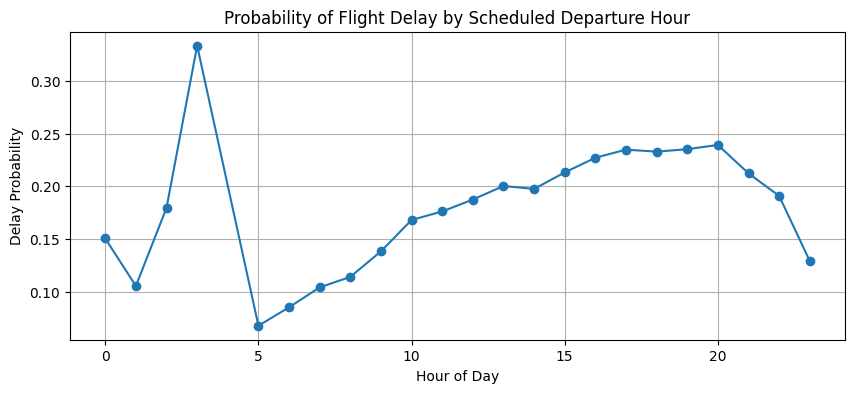

distance_bin
(15.999, 296.0]     0.149955
(296.0, 484.0]      0.192686
(484.0, 760.0]      0.179995
(760.0, 1099.0]     0.188419
(1099.0, 4983.0]    0.179272
Name: delayed, dtype: float64


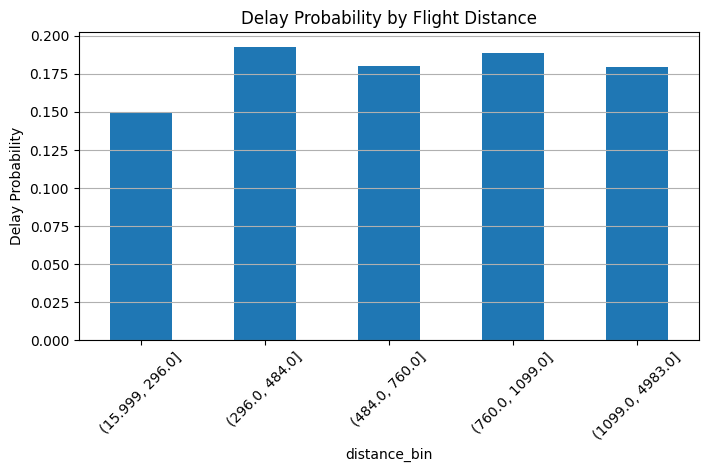

In [ ]:


plt.figure(figsize=(10,4))
hour_delay.plot(kind="line", marker="o")
plt.title("Probability of Flight Delay by Scheduled Departure Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Delay Probability")
plt.grid(True)
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# Crear bins de distancia (5 quintiles)
df_sample["distance_bin"] = pd.qcut(df_sample["Distance"], q=5)

# Calcular probabilidad de retraso por rango de distancia
distance_delay = (
    df_sample.groupby("distance_bin", observed=True)["delayed"]
    .mean()
)


print(distance_delay)

plt.figure(figsize=(8,4))
distance_delay.plot(kind="bar")
plt.title("Delay Probability by Flight Distance")
plt.ylabel("Delay Probability")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

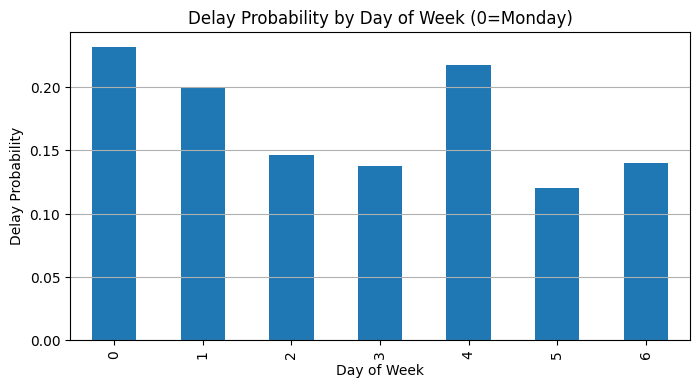

Marketing_Airline_Network
F9    0.253666
WN    0.216401
AA    0.216376
DL    0.177156
UA    0.142849
NK    0.125656
HA    0.097418
AS    0.097102
Name: delayed, dtype: float64


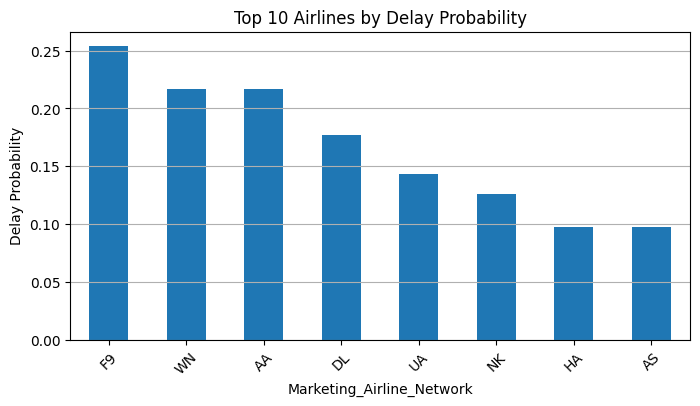

Std of delay probability by hour: 0.0617


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir a datetime
df_sample["FlightDate"] = pd.to_datetime(df_sample["FlightDate"])

# Crear día de la semana (0 = lunes)
df_sample["day_of_week"] = df_sample["FlightDate"].dt.dayofweek

# Calcular probabilidad de retraso por día de la semana
dow_delay = (
    df_sample.groupby("day_of_week")["delayed"]
    .mean()
    .sort_index()
)

# Graficar
plt.figure(figsize=(8,4))
dow_delay.plot(kind="bar")
plt.title("Delay Probability by Day of Week (0=Monday)")
plt.xlabel("Day of Week")
plt.ylabel("Delay Probability")
plt.grid(axis="y")
plt.show()

import matplotlib.pyplot as plt

# Probabilidad de retraso por aerolínea (top 10)
already_delay = (
    df_sample.groupby("Marketing_Airline_Network")["delayed"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Mostrar resultados
print(already_delay)

# Graficar
plt.figure(figsize=(8,4))
already_delay.plot(kind="bar")
plt.title("Top 10 Airlines by Delay Probability")
plt.ylabel("Delay Probability")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# Comprobación de variable objetivo binaria
df_sample["delayed"].value_counts(normalize=True)

hour_delay = (
    df_sample.groupby("hour")["delayed"]
    .mean()
)

hour_std = hour_delay.std()

print(f"Std of delay probability by hour: {hour_std:.4f}")

# Este criterio mide cuánto cambia la probabilidad de retraso a lo largo del día;
# si la variación es alta, significa que la hora del vuelo influye de forma real
# en los retrasos, y el ratio entre datasets nos permite comparar cuál captura
# mejor ese patrón temporal sin necesidad de entrenar ni optimizar modelos.

# Al medir la variación de la probabilidad de retraso según la hora, verificamos
# que la hora del vuelo tiene impacto real, y usando el ratio podemos decidir
# qué dataset conserva mejor esa señal predictiva sin incurrir en mayor coste
# computacional.

# Task
Calculate the minimum statistical sample size required to estimate the proportion of delayed flights with a 95% confidence level and a 1% margin of error, considering the total population size (30,132,672) and the observed delay rate (0.17801) from the current sample. Explain the key factors influencing sample size determination and evaluate whether the current 100,000-row sample is sufficient for general exploratory analysis and what it implies for further work.

## Explain Sample Size Factors

### Subtask:
Explain the key factors influencing the determination of a minimum sample size, such as population size, desired confidence level, and acceptable margin of error. Emphasize that 'minimum' is context-dependent.


### 1. Definition of Minimum Statistical Sample Size

The **minimum statistical sample size** refers to the smallest number of observations or data points required from a population to achieve a specified level of statistical accuracy and confidence when estimating a population parameter, such as a population proportion. It is not an arbitrary number but is derived from statistical formulas that balance the desire for precision with the practical constraints of data collection. In essence, it's the sample size needed to ensure that our estimate of the true population proportion falls within a certain margin of error with a given probability (confidence level).

### 2. Population Size (N)

The **population size (N)** is the total number of individuals or items in the entire group from which the sample is drawn. For very large populations (theoretically infinite or practically much larger than the sample), the population size has little impact on the required sample size. In such cases, the finite population correction (FPC) factor is not typically used, and the sample size is determined primarily by the desired confidence level, margin of error, and estimated population proportion.

However, when the sample size (n) is a significant proportion of the population size (e.g., more than 5% of N), the **finite population correction factor (FPC)** needs to be applied. The FPC reduces the required sample size because, as you sample a larger fraction of a finite population, the uncertainty about the remaining unsampled portion decreases. The formula for the FPC is often given as $\sqrt{(N-n)/(N-1)}$. When used, it effectively reduces the variance of the sample proportion, leading to a smaller required sample size for the same level of precision.

### 3. Confidence Level

The **confidence level** expresses the degree of certainty that the true population parameter (e.g., the true population proportion) lies within the calculated confidence interval. Common confidence levels are 90%, 95%, and 99%. A higher confidence level indicates a greater desire for certainty, which in turn requires a larger sample size to achieve the same margin of error. For instance, a 99% confidence level implies that if we were to take many samples and construct a confidence interval from each, 99% of these intervals would contain the true population proportion.

The confidence level is directly tied to the **Z-score (or critical value)**. The Z-score is the number of standard deviations a data point is from the mean of a standard normal distribution. For a given confidence level, the Z-score defines the boundaries within which a certain percentage of the data falls. For example:

*   **90% Confidence Level:** Z-score ≈ 1.645
*   **95% Confidence Level:** Z-score ≈ 1.96
*   **99% Confidence Level:** Z-score ≈ 2.576

These Z-scores are derived from the standard normal distribution table and represent the critical values that correspond to the desired level of confidence. A larger Z-score (corresponding to a higher confidence level) will result in a larger required sample size, as more data is needed to be more certain about the estimate.

### 4. Margin of Error (E)

The **margin of error (E)**, often denoted by `e`, is the maximum allowable difference between the sample estimate (e.g., sample proportion) and the true population parameter. It quantifies the precision of our estimate. A smaller margin of error implies a more precise estimate, meaning our sample estimate is expected to be closer to the true population value. Conversely, a larger margin of error suggests less precision.

The margin of error is a critical component in the sample size formula because it directly dictates the width of the confidence interval. For a given confidence level, a smaller desired margin of error requires a significantly larger sample size. This is an intuitive relationship: to be more confident that your sample estimate is very close to the true population value (i.e., a small margin of error), you need to collect more data. The relationship is often inverse-square; for example, to halve the margin of error, you typically need to quadruple the sample size.

### 5. Estimated Population Proportion ($\\hat{p}$)

The **estimated population proportion ($\\hat{p}$)**, sometimes referred to as the anticipated proportion or preliminary estimate, is a crucial component in sample size calculation formulas for proportions. It represents our best guess of the true proportion of the characteristic of interest in the population.

The sample size formula for proportions is often: $n = \frac{Z^2 \cdot \hat{p}(1-\hat{p})}{E^2}$, where $Z$ is the Z-score, $E$ is the margin of error, and $\\hat{p}$ is the estimated population proportion.

*   **Impact on Sample Size:** The term $\\hat{p}(1-\hat{p})$ is maximized when $\\hat{p} = 0.5$. This means that using $\\hat{p} = 0.5$ in the sample size formula will yield the largest possible sample size for a given confidence level and margin of error. Consequently, if there is no prior knowledge or estimate of the population proportion, setting $\\hat{p} = 0.5$ is a **conservative approach**. It ensures that the calculated sample size will be sufficient, even if the true proportion is far from 0 or 1, providing the maximum possible sample size and thus adequate statistical power to detect the effect.

*   **When a Prior Estimate is Available:** If a prior estimate of the population proportion is available (e.g., from previous studies, pilot surveys, or expert knowledge), it should be used instead of 0.5. Using a more accurate estimate of $\\hat{p}$ can potentially lead to a smaller, yet still adequate, required sample size, thereby optimizing resource allocation for data collection.

### 5. Estimated Population Proportion ($\hat{p}$)

The **estimated population proportion ($\hat{p}$)**, sometimes referred to as the anticipated proportion or preliminary estimate, is a crucial component in sample size calculation formulas for proportions. It represents our best guess of the true proportion of the characteristic of interest in the population.

The sample size formula for proportions is often: $n = \frac{Z^2 \cdot \hat{p}(1-\hat{p})}{E^2}$, where $Z$ is the Z-score, $E$ is the margin of error, and $\hat{p}$ is the estimated population proportion.

*   **Impact on Sample Size:** The term $\hat{p}(1-\hat{p})$ is maximized when $\hat{p} = 0.5$. This means that using $\hat{p} = 0.5$ in the sample size formula will yield the largest possible sample size for a given confidence level and margin of error. Consequently, if there is no prior knowledge or estimate of the population proportion, setting $\hat{p} = 0.5$ is a **conservative approach**. It ensures that the calculated sample size will be sufficient, even if the true proportion is far from 0 or 1, providing the maximum possible sample size and thus adequate statistical power to detect the effect.

*   **When a Prior Estimate is Available:** If a prior estimate of the population proportion is available (e.g., from previous studies, pilot surveys, or expert knowledge), it should be used instead of 0.5. Using a more accurate estimate of $\hat{p}$ can potentially lead to a smaller, yet still adequate, required sample size, thereby optimizing resource allocation for data collection.

### 6. Context-Dependent Nature of 'Minimum' Sample Size

It is crucial to understand that the concept of a "minimum" sample size is not a fixed, universal number, but is **highly context-dependent**. The definition of "minimum" is shaped by the specific research question, the desired level of precision, the practical constraints of the study, and the characteristics of the population being studied.

Factors such as:

*   **Type of Study:** Different types of research (e.g., descriptive, comparative, experimental) may have varying statistical requirements.
*   **Complexity of Analysis:** Studies involving multivariate analyses or subgroup comparisons often require larger samples.
*   **Practical Constraints:** Budget, time, and accessibility of the population can limit the feasible sample size.
*   **Consequences of Error:** In fields where the cost of making an incorrect decision is high (e.g., medical research, quality control), a larger sample size may be justified to minimize the risk of error.

Therefore, determining the "minimum" sample size involves a careful balance between statistical rigor, ethical considerations, and practical realities. It's not just about meeting a formulaic requirement, but about ensuring the sample is sufficiently large to answer the research question with meaningful and reliable results, given the specific circumstances of the study. There is no one-size-fits-all answer, and a thoughtful consideration of all these factors is necessary.

### 6. Context-Dependent Nature of 'Minimum' Sample Size

It is crucial to understand that the concept of a "minimum" sample size is not a fixed, universal number, but is **highly context-dependent**. The definition of "minimum" is shaped by the specific research question, the desired level of precision, the practical constraints of the study, and the characteristics of the population being studied.

Factors such as:

*   **Type of Study:** Different types of research (e.g., descriptive, comparative, experimental) may have varying statistical requirements.
*   **Complexity of Analysis:** Studies involving multivariate analyses or subgroup comparisons often require larger samples.
*   **Practical Constraints:** Budget, time, and accessibility of the population can limit the feasible sample size.
*   **Consequences of Error:** In fields where the cost of making an incorrect decision is high (e.g., medical research, quality control), a larger sample size may be justified to minimize the risk of error.

Therefore, determining the "minimum" sample size involves a careful balance between statistical rigor, ethical considerations, and practical realities. It's not just about meeting a formulaic requirement, but about ensuring the sample is sufficiently large to answer the research question with meaningful and reliable results, given the specific circumstances of the study. There is no one-size-fits-all answer, and a thoughtful consideration of all these factors is necessary.

## Calculate Minimum Statistical Sample Size

### Subtask:
Calculate the statistically minimum sample size required to estimate the proportion of delayed flights (using the `delayed` variable) with a 95% confidence level and a 1% margin of error, considering the total population size (`num_filas`) and the observed `delay_rate` from the current sample. Provide the formula and the resulting number.


**Reasoning**:
I will calculate the minimum statistical sample size required to estimate the proportion of delayed flights by defining the necessary parameters, including population size, estimated proportion, confidence level, and margin of error, and then applying the appropriate formulas for initial and finite population corrected sample sizes.



In [5]:
import numpy as np

# 1. Define the population size (N) and estimated population proportion (p_hat)
N = num_filas  # Total population size
p_hat = delay_rate  # Observed delay rate from the current sample
E = 0.01  # Margin of error (1%)

# 2. Determine the Z-score for a 95% confidence level
Z = 1.96  # Z-score for 95% confidence level

# 3. Calculate the initial sample size (n0)
n0 = (Z**2 * p_hat * (1 - p_hat)) / (E**2)

# 4. Calculate the final sample size (n) using Finite Population Correction (FPC)
n = n0 / (1 + (n0 - 1) / N)

# 5. Print the calculated values
print(f"Population Size (N): {N}")
print(f"Estimated Population Proportion (p_hat): {p_hat:.4f}")
print(f"Margin of Error (E): {E:.2f}")
print(f"Z-score for 95% Confidence Level: {Z}")
print(f"Initial Sample Size (n0): {n0:.2f}")
print(f"Final Minimum Statistical Sample Size (n): {n:.0f}")

Population Size (N): 30132672
Estimated Population Proportion (p_hat): 0.1780
Margin of Error (E): 0.01
Z-score for 95% Confidence Level: 1.96
Initial Sample Size (n0): 5621.12
Final Minimum Statistical Sample Size (n): 5620


### Evaluation of Current Sample Sufficiency and Implications

#### 1. Sufficiency for General Exploratory Analysis

The calculated minimum statistical sample size required to estimate the proportion of delayed flights with a 95% confidence level and a 1% margin of error is **5,620** rows. The current sample size used for exploratory analysis is **100,000** rows.

Since 100,000 is significantly larger than the calculated minimum of 5,620, the current 100,000-row sample is **more than sufficient** for general exploratory analysis regarding the proportion of delayed flights. This sample size provides a high degree of confidence and a small margin of error, meaning that the observations and statistics derived from this sample (like the delay rate, hourly delay probability, etc.) are highly representative of the overall population of 30 million flights within the specified precision.

#### 2. Implications for Further Work

*   **Reliability of Findings:** The analyses performed on the 100,000-row sample (e.g., probability of delay by hour, distance, day of week, or airline) are statistically reliable. The patterns and trends identified are very likely to hold true for the entire dataset.

*   **Efficiency:** While 100,000 rows are sufficient, it's also worth noting that for tasks specifically related to estimating the overall delay proportion, one could have used a much smaller sample (around 5,620 rows) and still achieved the desired precision. However, for more complex exploratory analysis involving subgroup comparisons or less frequent events, a larger sample like 100,000 rows offers more statistical power and finer-grained insights.

*   **Model Training:** For building predictive models, a larger sample is generally better as it helps the model learn more complex relationships and generalize well. The 100,000-row sample is a good starting point, but depending on the complexity of the model and the rarity of certain features or outcomes, using the full dataset or an even larger sample might be beneficial for final model training.

*   **Resource Management:** If computational resources or time were a significant constraint, knowing the minimum sample size allows for efficient data usage. In this case, processing 100,000 rows is manageable. However, if the full dataset were much larger and the exploratory analysis was computationally intensive, the minimum sample size calculation would guide us to a smaller, yet statistically valid, sample to save resources.

## Final Task

### Subtask:
Summarize the findings regarding the minimum sample size and the adequacy of the current sample for various types of analysis.


## Summary:

### Q&A

1.  **What is the minimum statistical sample size required to estimate the proportion of delayed flights with a 95% confidence level and a 1% margin of error, given the total population size (30,132,672) and an observed delay rate (0.17801)?**
    The calculated minimum statistical sample size required is 5,620 rows.
2.  **What are the key factors influencing sample size determination?**
    The key factors influencing sample size determination are:
    *   **Population Size (N):** The total number of individuals or items in the group.
    *   **Confidence Level:** The degree of certainty that the true population parameter lies within the calculated confidence interval (e.g., 95% confidence corresponds to a Z-score of 1.96).
    *   **Margin of Error (E):** The maximum allowable difference between the sample estimate and the true population parameter (e.g., 1%).
    *   **Estimated Population Proportion ($\hat{p}$):** The best guess of the true proportion of the characteristic of interest in the population. Using 0.5 is a conservative approach when no prior estimate is available, yielding the largest sample size.
    *   **Context-Dependent Nature:** The definition of "minimum" is highly dependent on the specific research question, desired precision, practical constraints, and complexity of analysis.
3.  **Is the current 100,000-row sample sufficient for general exploratory analysis?**
    Yes, the current 100,000-row sample is more than sufficient for general exploratory analysis, as it is significantly larger than the statistically required minimum of 5,620 rows.
4.  **What does the sufficiency of the current sample imply for further work?**
    The sufficiency implies that analyses performed on the 100,000-row sample are statistically reliable, and identified patterns are likely to hold true for the entire dataset. It also suggests that the sample is a good starting point for predictive model training and offers more statistical power for complex exploratory analyses or rare events than the minimum required size.

### Data Analysis Key Findings

*   The minimum statistical sample size required to estimate the proportion of delayed flights with a 95% confidence level and a 1% margin of error is **5,620** rows, after applying the Finite Population Correction to an initial calculation of 5,621.12.
*   The current sample of **100,000** rows is significantly larger than the calculated minimum, making it **more than sufficient** for general exploratory analysis.
*   The observed delay rate ($\hat{p}$) from the current sample, used in the calculation, was approximately 0.1780.
*   The large sample size ensures that findings derived from the current sample regarding delay proportions are highly representative of the overall population of 30,132,672 flights.

### Insights or Next Steps

*   **Leverage existing sample for complex analysis:** Since the 100,000-row sample is robust, it can be confidently used for more granular exploratory analysis, subgroup comparisons, or detecting less frequent events, which might require more statistical power than the minimum calculated sample size.
*   **Optimize resource allocation for specific tasks:** For tasks solely focused on estimating the overall delay proportion, a smaller sample closer to the calculated 5,620 rows could be used to conserve computational resources without sacrificing statistical precision. For predictive modeling, the 100,000-row sample is a good starting point, but the full dataset might be considered for final model training to capture maximum variance and improve generalization.
